In [3]:
import pandas as pd
from os.path import basename
from ugvc.reports import report_utils
from ugvc.reports.report_utils import ReportUtils
from ugvc.reports.report_data_loader import ReportDataLoader
from IPython.display import display, Markdown
import seaborn as sns
from matplotlib import pyplot as plt
pd.options.display.float_format = '{:,.2%}'.format
pd.set_option('display.max_colwidth', None)
sns.set_theme(style="whitegrid")
sns.set_context("talk")

In [ ]:
run_id = "NA"
pipeline_version = "NA"
statistics_file = "<fillhere>.pkl"
reference_version = "hg38"
truth_sample_name = "NA"
h5outfile = "var_report.h5"    


In [5]:
parameters = {
    'statistics_file': statistics_file,
    'run_id': run_id,
    'reference_version': reference_version,
    'pipeline_version': str(pipeline_version),
    'truth_sample_name': truth_sample_name,
    'h5outfile': h5outfile,
}

parameters = {name: parameters[name] for name in parameters if parameters[name] is not None}
param_names = list(parameters)

report_utils = ReportUtils(1, h5outfile)

display(Markdown(f"# SV/CNV Calling report {pipeline_version} (INTERNAL usage)"))


# SV/CNV Calling report NA (INTERNAL usage)

## 1. Input Parameters <a class="anchor" id="input_parameters"></a>

In [6]:
# load data
data_loader = ReportDataLoader(concordance_file=parameters['statistics_file'],
                               reference_version=parameters['reference_version'],
                               exome_column_name = "exome.twist"
)
data_no_gt, data_gt = data_loader.load_sv_concordance_df()
has_concordance_data = len(data_gt)>0

In [7]:
parameters_df = pd.DataFrame.from_dict(parameters, orient='index', columns=['value']).reindex(param_names)
parameters_df.loc['statistics_file', 'value'] = basename(str(parameters_df.loc['statistics_file', 'value']))
parameters_df.to_hdf(h5outfile, key="parameters")
display(parameters_df)

,value
statistics_file,test.stats.pkl
run_id,NA
reference_version,hg38
pipeline_version,NA
truth_sample_name,NA
h5outfile,var_report.h5


In [8]:
anchor = report_utils.get_anchor("top")
display(Markdown(f"## Table of Contents {anchor}"))
tc = "* [Input Parameters](#input_parameters)\n"
tc += "* [General statistics](#general_statistics)\n"
if has_concordance_data:
    tc += "* [Accuracy](#concordance_eval)\n"

display(Markdown(tc))

## Table of Contents <a class ='anchor' id='top'> </a>

* [Input Parameters](#input_parameters)
* [General statistics](#general_statistics)
* [Accuracy](#concordance_eval)


## General statistics  <a class='anchor' id='all_data'></a>

The tables below summarize class and length distributions of called SVs


### SV type distribution

In [9]:
pd.options.display.float_format = '{:,.2%}'.format
data_no_gt['type_counts'].name = 'SV type'
data_no_gt['type_counts'] = pd.DataFrame(data_no_gt['type_counts']).T

In [10]:
data_no_gt['type_counts'].to_hdf(h5outfile, key="type_counts")

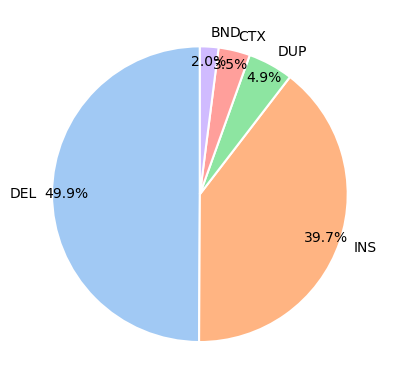

In [11]:
# Pie chart of data_no_gt['type_counts']
fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(data_no_gt['type_counts'].values[0],
                                   labels=data_no_gt['type_counts'].columns,
                                   autopct='%1.1f%%',
                                   startangle=90,
                                   colors=sns.color_palette("pastel"),
                                    pctdistance=0.9,         # keep percentages inside
                                    labeldistance=1.1,        # move labels outside

                                   textprops=dict(color="b"))
for text in texts + autotexts:
    text.set_color("black")
    text.set_fontsize(10)

### SV length distribution

In [12]:
data_no_gt['length_counts'].name = 'SV Length'
data_no_gt['length_counts'] = pd.DataFrame(data_no_gt['length_counts']).T
data_no_gt['length_counts']

,50-100,100-300,300-500,0.5-1k,1k-5k,5k-10k,10k-100k,100k-1M,>1M
SV Length,11669,2943,3114,316,580,130,82,17,53


In [13]:
data_no_gt['length_counts'].columns = data_no_gt['length_counts'].columns.astype(str)
data_no_gt['length_counts'].to_hdf(h5outfile, key="length_counts")

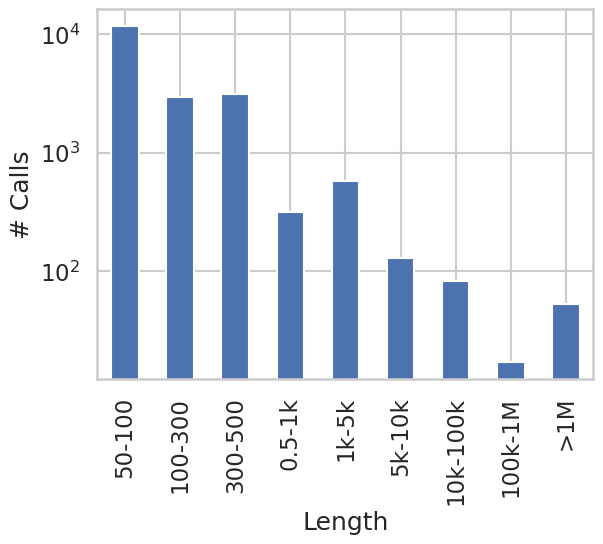

In [14]:
data_no_gt['length_counts'].T.plot.bar(legend=False)
plt.xlabel("Length")
plt.ylabel('# Calls')
# set y axis log scale
plt.yscale('log')


### Length and type distribution

In [15]:
data_no_gt['length_by_type_counts']

binned_svlens,50-100,100-300,300-500,0.5-1k,1k-5k,5k-10k,10k-100k,100k-1M,>1M
svtype,,,,,,,,,
BND,42,55,36,58,110,12,22,8,40
DEL,6365,1167,1099,210,431,110,48,5,1
DUP,578,187,54,41,39,8,12,4,12
INS,4031,1534,1925,7,0,0,0,0,0


In [16]:
data_no_gt['length_by_type_counts'] = data_no_gt['length_by_type_counts'].T

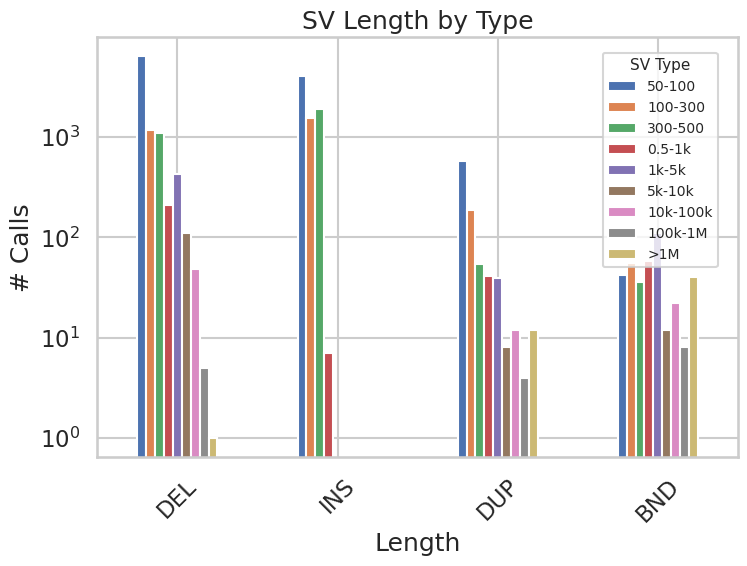

In [17]:
# Make sure the SV types are in the desired order
desired_order = ['DEL', 'INS', 'DUP', 'BND']
df = data_no_gt['length_by_type_counts']
df = df.set_index('svtype') if 'svtype' in df.columns else df
df = df.reindex(desired_order,axis=1).dropna(how='all',axis=1)

# Plot with legend inside and correct order
ax = df.T.plot(kind='bar', stacked=False, figsize=(8, 6))
plt.xlabel("Length")
plt.ylabel('# Calls')
plt.title('SV Length by Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(
    title='SV Type',
    loc='upper right',   # inside the plot
    bbox_to_anchor=(0.98, 0.98),
    fontsize=10,
    title_fontsize=11
)
plt.yscale('log')
plt.show()


In [18]:
data_no_gt['length_by_type_counts'].to_hdf(h5outfile, key="length_by_type_counts")

In [19]:
if has_concordance_data:
    anchor = report_utils.get_anchor('concordance_eval')
    display(Markdown(f"## Concordance evaluation {anchor}"))


## Concordance evaluation <a class ='anchor' id='concordance_eval'> </a>

In [20]:
if has_concordance_data:
    display(Markdown(f"### Overall concordance"))
    concordance_df = data_gt['concordance'].copy()


### Overall concordance

In [21]:
if has_concordance_data:
    display(Markdown("Recall and precision with comparison to ground truth. Note that the categories of the variants in ground truth may be different from the callset. "
                     "In the evaluation we do not compare the variant type in the callset to that of the truth set."))
    values_df = concordance_df.drop(['precision roc', 'recall roc','thresholds'],axis=1).query('`SV length`==""').droplevel(1,axis=0)
    values_df = values_df[['TP_base', 'TP_calls', 'FP', 'FN','Recall','Precision','F1']]
    roc_df    = concordance_df.query('`SV length`==""').droplevel(1,axis=0)[['precision roc', 'recall roc','thresholds']]
    # show pandas representation for TP_base, TP_calls, FP and FN as integers
    values_df[['TP_base', 'TP_calls', 'FP', 'FN']] = values_df[['TP_base', 'TP_calls', 'FP', 'FN']].astype(int)
    values_df = values_df.loc[values_df['TP_base'] > 0] # remove cases absent from ground truth
    roc_df = roc_df.loc[values_df.index]
    display(values_df)
    values_df.to_hdf(h5outfile, key="recall_per_type")

Recall and precision with comparison to ground truth. Note that the categories of the variants in ground truth may be different from the callset. In the evaluation we do not compare the variant type in the callset to that of the truth set.

,TP_base,TP_calls,FP,FN,Recall,Precision,F1
SV type,,,,,,,
ALL,9341,9341,1958,13192,41.45%,82.67%,55.22%
DEL,4497,4745,367,4662,49.10%,92.82%,64.23%
INS,4844,4011,591,8530,36.22%,87.16%,51.17%


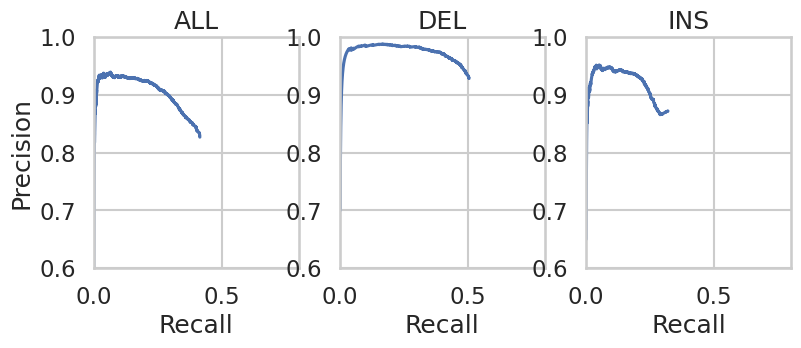

In [22]:
if has_concordance_data:
    fig,ax = plt.subplots(1,roc_df.shape[0],figsize=(roc_df.shape[0]*3,3))
    for i,v in enumerate(roc_df.iterrows()):
        plt.subplot(1,roc_df.shape[0],i+1)
        plt.plot(v[1]['recall roc'],v[1]['precision roc'])
        plt.title(v[0])
        plt.xlabel('Recall')
        plt.xlim(0,0.8)
        plt.ylim(0.6,1)
    ax[0].set_ylabel("Precision")


In [23]:
if has_concordance_data:
    display(Markdown(f"### Recall per variant length and type"))
    concordance_df = data_gt['concordance'].copy()
    values_df = concordance_df.drop(['precision roc', 'recall roc','thresholds'],axis=1).query('`SV length`!=""')
    values_df = values_df[['TP_base', 'TP_calls', 'FN','Recall']]
    values_df[['TP_base','TP_calls','FN']] = values_df[['TP_base','TP_calls','FN']].astype(int)
    display(values_df)
    values_df.index = values_df.index.rename({'SV length':'SV_length', 'SV type':'SV_type'})
    values_df.to_hdf(h5outfile, key="recall_per_length_and_type")


### Recall per variant length and type

TP_base  TP_calls    FN  Recall
SV type SV length                                 
ALL     50-100        3171      3684  4365  42.08%
        100-300       2124      2124  4416  32.48%
        300-500       2308      2734  1692  57.70%
        0.5-1k         611       232  1193  33.87%
        1k-5k          899       417  1210  42.63%
        5k-10k         183       109   162  53.04%
        10k-100k        45        41   154  22.61%
        100k-1M          0         0     0   0.00%
        >1M              0         0     0   0.00%
DEL     50-100        1751      2051  1758  49.90%
        100-300        955       919  1555  38.05%
        300-500       1070      1049   559  65.68%
        0.5-1k         195       197   348  35.91%
        1k-5k          391       391   334  53.93%
        5k-10k         104       105    48  68.42%
        10k-100k        31        33    60  34.07%
        100k-1M          0         0     0   0.00%
        >1M              0         0     0   0.00%
INS     50-100        1420      1309  2607  35.26%
        100-300       1169      1057  2861  29.01%
        300-500       1238      1640  1133  52.21%
        0.5-1k         416         5   845  32.99%
        1k-5k          508         0   876  36.71%
        5k-10k          79         0   114  40.93%
        10k-100k        14         0    94  12.96%
        100k-1M          0         0     0   0.00%
        >1M              0         0     0   0.00%

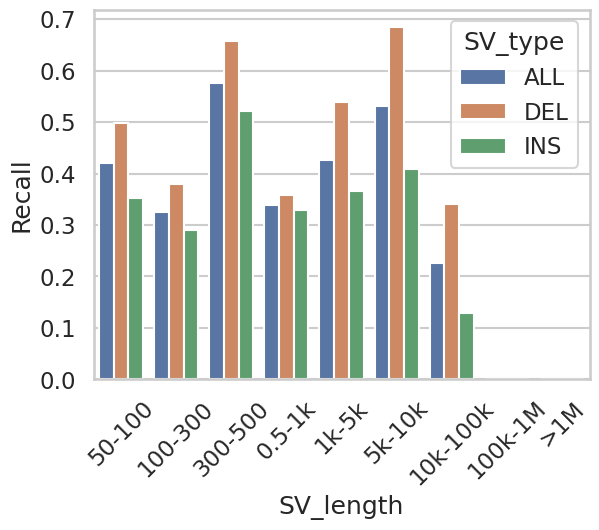

In [24]:
if has_concordance_data:
    sns.barplot(data=values_df.reset_index(), x='SV_length', y='Recall', hue='SV_type')
    plt.xticks(rotation=45);

In [ ]:
if has_concordance_data:
    display(Markdown(f"### False positives per variant length and type"))
    fp_df = data_gt['fp_stats'].copy()
    # Convert the series fp_df to dataframe by making the first level of index columns
    fp_df = fp_df.reset_index()
    fp_df.columns = ['SV length', 'SV type', 'FP count']
    fp_df = fp_df.pivot(index='SV length', columns='SV type', values='FP count').fillna(0).astype(int)
    display(fp_df)
    fp_df.plot.bar(figsize=(10, 5), width=0.8)
    #place legend outside
    plt.legend(title='SV Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    fp_df.to_hdf(h5outfile, key="fp_counts_per_length_and_type")

### False positives per variant length and type

SV type,50-100,100-300,300-500,0.5-1k,1k-5k,5k-10k,10k-100k,100k-1M,>1M
SV length,,,,,,,,,
BND,23,37,36,58,108,12,22,8,30
DEL,122,186,35,4,17,1,2,0,0
DUP,7,3,2,6,1,2,0,0,0
INS,122,296,173,0,0,0,0,0,0
